In [2]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.visualization import plot_histogram
from qiskit.algorithms.optimizers import COBYLA

from qiskit import *
import qiskit.quantum_info as qi
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import *
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
pi = math.pi

## Biased Pauli Noise
Here we will be considering Biased Pauli


In [2]:
noise_model = NoiseModel()

p_err = 0.02
b_err = 0.0050
error_1q = pauli_error([('I',1-p_err-b_err),('X',p_err/3),('Y',p_err/3),('Z',p_err/3+b_err)]) # 1 qubit Biased Pauli error
noise_model.add_all_qubit_quantum_error(error_1q, ['delay']) 

backend = AerSimulator(noise_model=noise_model)

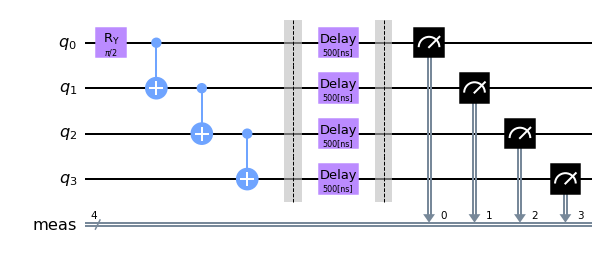

In [3]:
def U_prep(n_qubits,theta):
  qc = QuantumCircuit(n_qubits)
  qc.ry(theta,0)
  for qubit in range(n_qubits-1):
    qc.cx(qubit,qubit+1)
  qc.barrier()
  return qc

qc_without_hadamard = U_prep(4,pi/2)
qc_without_hadamard.delay(500,unit='ns')
qc_without_hadamard.measure_all()
qc_without_hadamard.draw('mpl')

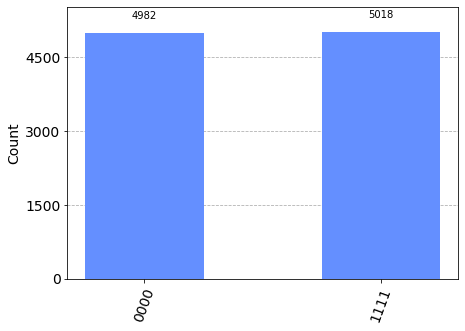

In [4]:
#Backend without Noise
results_ideal = AerSimulator().run(qc_without_hadamard,shots=10000).result()
counts_ideal = results_ideal.get_counts()
plot_histogram(counts_ideal)


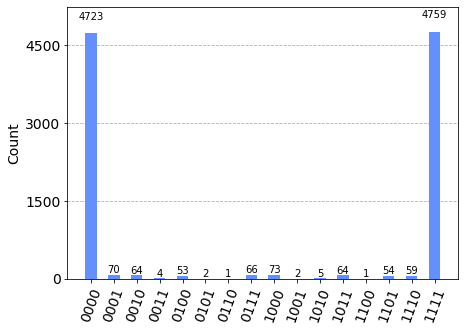

In [5]:
#Backend with noise
counts_without_hadamard = backend.run(qc_without_hadamard,shots=10000).result().get_counts()
plot_histogram(counts_without_hadamard)

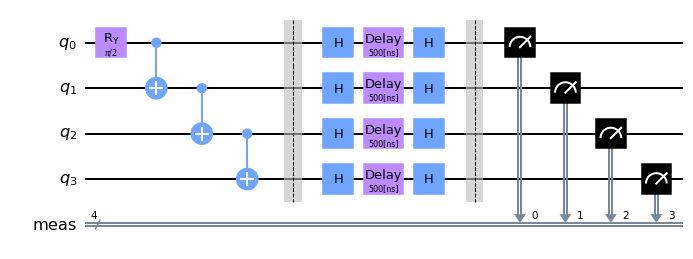

In [6]:
def padded_circuit(n_qubits,theta,delay):
  qc = U_prep(n_qubits,theta)

  for qubit in range(n_qubits):
    qc.h(qubit)
    qc.delay(delay,qubit,unit='ns')
    qc.h(qubit)
  qc.measure_all()
  return qc

qc_with_hadamard = padded_circuit(4,pi/2, 500)
qc_with_hadamard.draw('mpl')


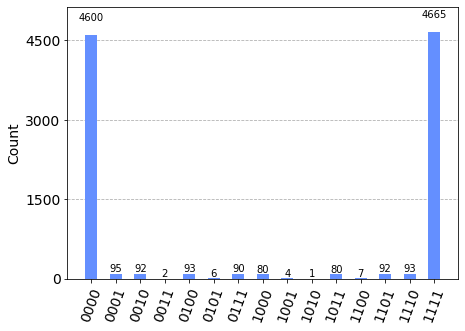

In [7]:
#Backend with Noise and padding both sides with the Hadamard gate
counts_with_hadamard = backend.run(qc_with_hadamard,shots=10000).result().get_counts()
plot_histogram(counts_with_hadamard)

In [8]:
# If state is not in the set of valid states, ouput is erroneous
def cost(counts):
  invalid_states_count = 0
  diff = 0
  counts = dict(counts)
  for state in counts.keys():
    if (state != '0000') and (state != '1111'):
      invalid_states_count += counts[state]
    # probability of getting the other 8 valid states is 5000/10000
    else:
        wt = counts[state]-5000
        if (wt >= 0):
            diff += wt # we got a valid state but how far is it from the ideal value? i.e deviation from correct value
  total_error = round((invalid_states_count + diff)/10000 , 4 )
  return {'invalid_states_count':invalid_states_count, 'deviation' : diff, 'error':total_error }


In [9]:
# counts = backend.run(qc,shots=10000).result().get_counts()
print(f"Error without noise: {cost(counts_ideal)}")
print(f"Error with noise without hadamard: {cost(counts_without_hadamard)}")
print(f"Error with noise with hadamard: {cost(counts_with_hadamard)}")

Error without noise: {'invalid_states_count': 0, 'deviation': 18, 'error': 0.0018}
Error with noise without hadamard: {'invalid_states_count': 518, 'deviation': 0, 'error': 0.0518}
Error with noise with hadamard: {'invalid_states_count': 735, 'deviation': 0, 'error': 0.0735}


### Addition of hadamard gate has increased the error rate

In [10]:
# Complete this function
def pad_circuits_with_gates(n_qubits,theta,delay):  
  qc = U_prep(n_qubits,theta)
  range_low, increment = 0, pi/32
  range_high = 2*pi - increment
  circuits = []
 
  
  angle1 = range_low
  while(angle1 <= range_high): # u = rx, v = rx
    angle2 = range_low
    while(angle2 <= range_high):

      qc_pad = qc.copy()

      for qubit in range(n_qubits):     # u = rx
        qc_pad.rx(angle1,qubit)

      qc_pad.delay(delay,unit='ns')

      for qubit in range(n_qubits):     # v = rx
        qc_pad.rx(angle2,qubit)
      
      qc_pad.measure_all()
      circuits.append((qc_pad, angle1,angle2))
      # a1.append(angle1)
      # a2.append(angle2)
      angle2 += increment
    angle1 += increment

  angle1 = range_low
  while(angle1 <= range_high): # u = rx, v = ry
    angle2 = range_low
    while(angle2 <= range_high):

      qc_pad = qc.copy()

      for qubit in range(n_qubits):     # u = rx
        qc_pad.rx(angle1,qubit)

      qc_pad.delay(delay,unit='ns')

      for qubit in range(n_qubits):     # v = ry
        qc_pad.ry(angle2,qubit)
      
      qc_pad.measure_all()
      circuits.append((qc_pad, angle1,angle2))
      # a1.append(angle1)
      # a2.append(angle2)
      angle2 += increment
    angle1 += increment

  angle1 = range_low
  while(angle1 <= range_high): # u = ry, v = rx
    angle2 = range_low
    while(angle2 <= range_high):

      qc_pad = qc.copy()

      for qubit in range(n_qubits):     # u = ry
        qc_pad.ry(angle1,qubit)

      qc_pad.delay(delay,unit='ns')

      for qubit in range(n_qubits):     # v = rx
        qc_pad.rx(angle2,qubit)
      
      qc_pad.measure_all()
      circuits.append((qc_pad, angle1,angle2))
      # a1.append(angle1)
      # a2.append(angle2)
      angle2 += increment
    angle1 += increment

  angle1 = range_low
  while(angle1 <= range_high): # u = ry, v = ry
    angle2 = range_low
    while(angle2 <= range_high):

      qc_pad = qc.copy()

      for qubit in range(n_qubits):     # u = ry
        qc_pad.ry(angle1,qubit)

      qc_pad.delay(delay,unit='ns')

      for qubit in range(n_qubits):     # v = ry
        qc_pad.ry(angle2,qubit)
      
      qc_pad.measure_all()
      circuits.append((qc_pad, angle1,angle2))
      # a1.append(angle1)
      # a2.append(angle2)
      angle2 += increment
    angle1 += increment

  return circuits

ckts = pad_circuits_with_gates(4,pi/2,500)

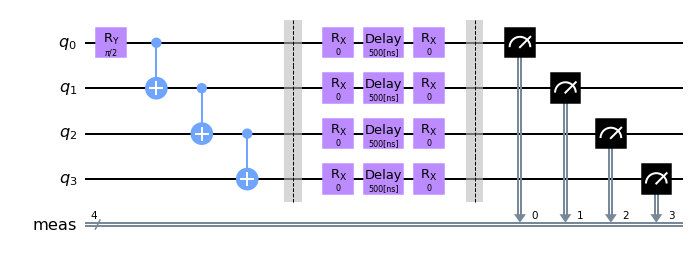

In [11]:
ckts[0][0].draw('mpl')

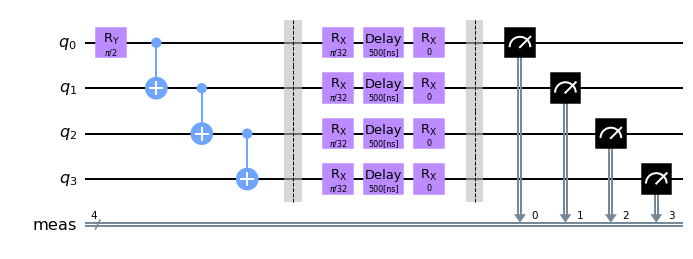

In [12]:
ckts[64][0].draw('mpl')

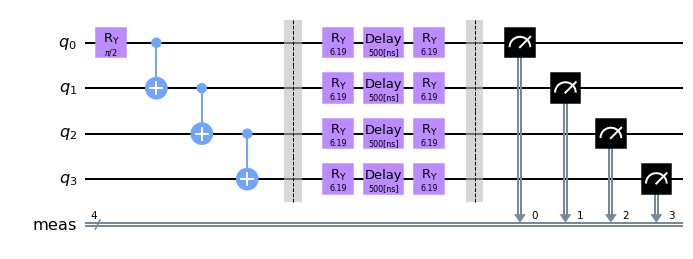

In [13]:
ckts[16383][0].draw('mpl')

In [14]:
def getError(ckt_info):
  return ckt_info['error']

Measuring error for all circutes and finding the circuit with least error

In [15]:
from tqdm import tqdm
min_error = 999999
min_err_info = None
min_ckt = None
theta = []
error = []

for ckt in tqdm(range(len(ckts))):
  qc = ckts[ckt][0]
  counts = backend.run(qc,shots=10000).result().get_counts()
  err = cost(counts)
  err['index'] = ckt
  error.append(err)

error.sort(key=getError)


100%|██████████| 16384/16384 [02:12<00:00, 124.06it/s]


In [19]:
print(error[0])

{'invalid_states_count': 482, 'deviation': 0, 'error': 0.0482, 'index': 3970}


Optimal circuit

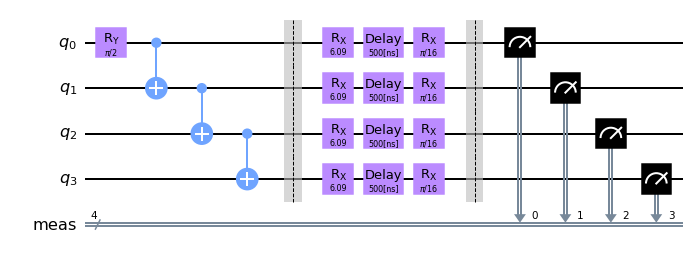

In [20]:
opt_idx = error[0]['index']
min_err_ckt = ckts[opt_idx][0]
min_err_ckt.draw('mpl')

In [21]:
errors = []
for i in range(len(ckts)):
  errors.append(error[i]['error'])

Plotting graphs

In [22]:
# for creating a responsive plot
%matplotlib widget

# Seprrating angles of U and V
x = np.array([ckt[:][1] for ckt in ckts ]) # U angle
x = np.array_split(x, len(x) / 4096)

y = np.array([ckt[:][2] for ckt in ckts ]) # V angle
y = np.array_split(y, len(y) / 4096)

z = np.array_split(np.array(errors), len(error)/4096 )

Error without applying any gate {'invalid_states_count': 518, 'deviation': 0, 'error': 0.0518}
Error after applying hadamard gate {'invalid_states_count': 735, 'deviation': 0, 'error': 0.0735}
Minimum error we found {'invalid_states_count': 482, 'deviation': 0, 'error': 0.0482, 'index': 3970}


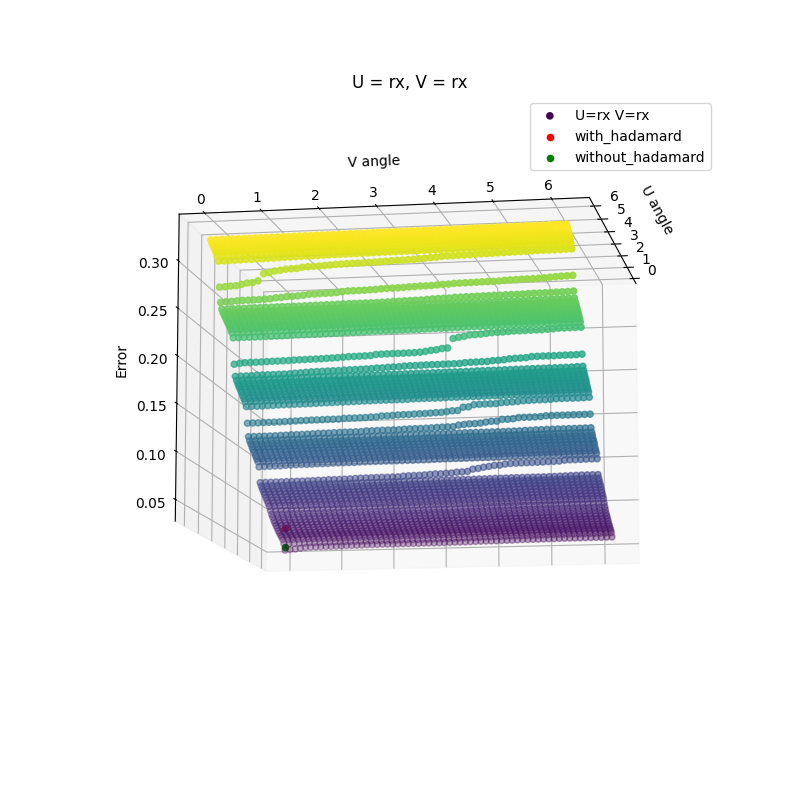

In [24]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.grid()
ax.set_title('U = rx, V = rx')
ax.set_xlabel('U angle')
ax.set_ylabel('V angle')
ax.set_zlabel('Error')

l1 = ax.scatter(x[0], y[0], z[0], c=z[0], cmap='viridis', label='U=rx V=rx')
l2 = ax.scatter(0,0,cost(counts_with_hadamard)['error'], color='red', label='with_hadamard')
l3 = ax.scatter(0,0,cost(counts_without_hadamard)['error'], color='green', label='without_hadamard')
ax.legend(handles=[l1, l2, l3])
ax.view_init(elev=-10, azim=10)

print(f"Error without applying any gate {cost(counts_without_hadamard)}")
print(f"Error after applying hadamard gate {cost(counts_with_hadamard)}")
print(f"Minimum error we found {error[0]}")
plt.show()

Error without applying any gate {'invalid_states_count': 518, 'deviation': 0, 'error': 0.0518}
Error after applying hadamard gate {'invalid_states_count': 735, 'deviation': 0, 'error': 0.0735}
Minimum error we found {'invalid_states_count': 482, 'deviation': 0, 'error': 0.0482, 'index': 3970}


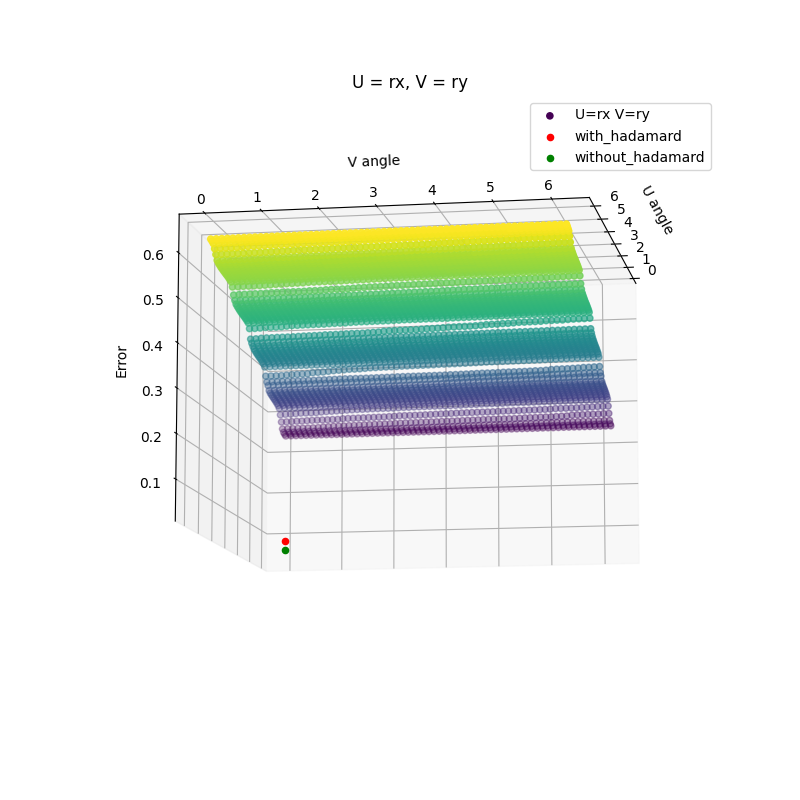

In [25]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.grid()
ax.set_title('U = rx, V = ry')
ax.set_xlabel('U angle')
ax.set_ylabel('V angle')
ax.set_zlabel('Error')

l1 = ax.scatter(x[1], y[1], z[1], c=z[1], cmap='viridis', label='U=rx V=ry')
l2 = ax.scatter(0,0,cost(counts_with_hadamard)['error'], color='red', label='with_hadamard')
l3 = ax.scatter(0,0,cost(counts_without_hadamard)['error'], color='green', label='without_hadamard')
ax.legend(handles=[l1, l2, l3])
ax.view_init(elev=-10, azim=10)
print(f"Error without applying any gate {cost(counts_without_hadamard)}")
print(f"Error after applying hadamard gate {cost(counts_with_hadamard)}")
print(f"Minimum error we found {error[0]}")
plt.show()

Error without applying any gate {'invalid_states_count': 518, 'deviation': 0, 'error': 0.0518}
Error after applying hadamard gate {'invalid_states_count': 735, 'deviation': 0, 'error': 0.0735}
Minimum error we found with U=ry V=rx {'invalid_states_count': 482, 'deviation': 0, 'error': 0.0482, 'index': 3970}


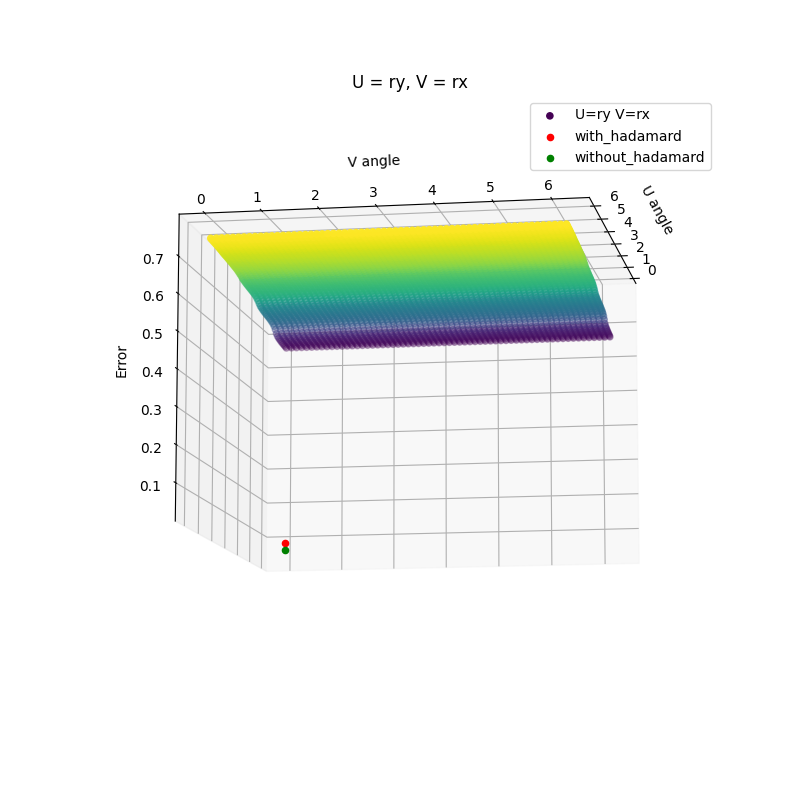

In [26]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.grid()
ax.set_title('U = ry, V = rx')
ax.set_xlabel('U angle')
ax.set_ylabel('V angle')
ax.set_zlabel('Error')

l1 = ax.scatter(x[2], y[2], z[2], c=z[2], cmap='viridis', label='U=ry V=rx')
l2 = ax.scatter(0,0,cost(counts_with_hadamard)['error'], color='red', label='with_hadamard')
l3 = ax.scatter(0,0,cost(counts_without_hadamard)['error'], color='green', label='without_hadamard')
ax.legend(handles=[l1, l2, l3])
ax.view_init(elev=-10, azim=10)
print(f"Error without applying any gate {cost(counts_without_hadamard)}")
print(f"Error after applying hadamard gate {cost(counts_with_hadamard)}")
print(f"Minimum error we found with U=ry V=rx {error[0]}")
plt.show()

Error without applying any gate {'invalid_states_count': 518, 'deviation': 0, 'error': 0.0518}
Error after applying hadamard gate {'invalid_states_count': 735, 'deviation': 0, 'error': 0.0735}
Minimum error we found with U=ry V=rx {'invalid_states_count': 482, 'deviation': 0, 'error': 0.0482, 'index': 3970}


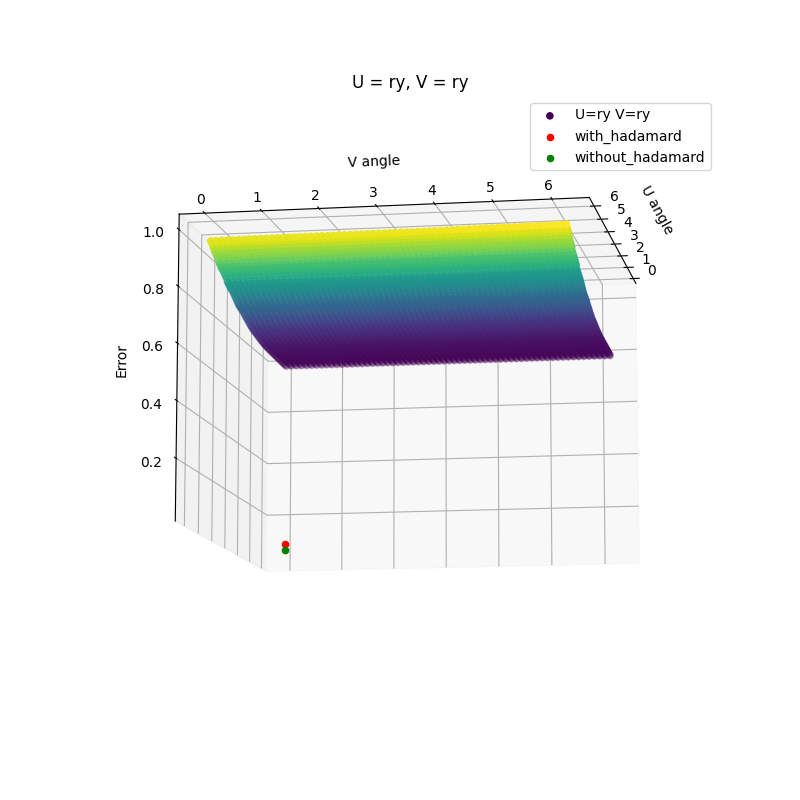

In [27]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.grid()
ax.set_title('U = ry, V = ry')
ax.set_xlabel('U angle')
ax.set_ylabel('V angle')
ax.set_zlabel('Error')

l1 = ax.scatter(x[3], y[3], z[3], c=z[3], cmap='viridis', label='U=ry V=ry')
l2 = ax.scatter(0,0,cost(counts_with_hadamard)['error'], color='red', label='with_hadamard')
l3 = ax.scatter(0,0,cost(counts_without_hadamard)['error'], color='green', label='without_hadamard')
ax.legend(handles=[l1, l2, l3])
ax.view_init(elev=-10, azim=10)
print(f"Error without applying any gate {cost(counts_without_hadamard)}")
print(f"Error after applying hadamard gate {cost(counts_with_hadamard)}")
print(f"Minimum error we found with U=ry V=rx {error[0]}")
plt.show()

## Now we wish to change the noise model

In [1]:
from biased_pauli_template import biased_pauli as bp
min_ckt, min_err_info, min_error = bp(p_err=0.03, b_err=0.005, delay_time=500)

100%|██████████| 16384/16384 [02:16<00:00, 120.45it/s]


In [3]:
print(min_err_info)

{'invalid_states_count': 710, 'deviation': 0, 'error': 0.071, 'index': 14431}


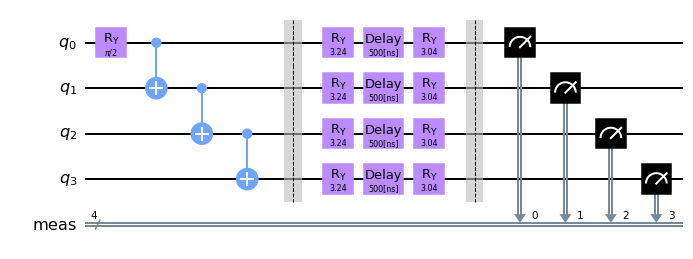

In [4]:
min_ckt.draw('mpl')

## And we run the same thing with different levels of noise and delay

In [6]:
from tqdm import tqdm
ckts_list = []
error_list = []
error_dict_list = []


for delay in (range(500, 1200, 200)):
  noise_prob = 0.005
  while (noise_prob <= 0.05):
    b_err = 0.0005
    while (b_err <= 0.001):
        print(f"@@@@@ noise_prob = {noise_prob} b_err = {b_err} delay = {delay}")
        min_ckt, min_err_info, min_error = bp(noise_prob, b_err, delay)
        ckts_list.append(min_ckt)
        error_dict_list.append(min_err_info)
        error_list.append(min_error)
        b_err += 0.0002
    noise_prob += 0.01

@@@@@ noise_prob = 0.005 b_err = 0.0005 delay = 500


100%|██████████| 16384/16384 [02:18<00:00, 118.02it/s]


@@@@@ noise_prob = 0.005 b_err = 0.0007 delay = 500


100%|██████████| 16384/16384 [02:19<00:00, 117.70it/s]


@@@@@ noise_prob = 0.005 b_err = 0.0009 delay = 500


100%|██████████| 16384/16384 [02:17<00:00, 118.92it/s]


@@@@@ noise_prob = 0.015 b_err = 0.0005 delay = 500


100%|██████████| 16384/16384 [02:17<00:00, 119.41it/s]


@@@@@ noise_prob = 0.015 b_err = 0.0007 delay = 500


100%|██████████| 16384/16384 [02:14<00:00, 122.08it/s]


@@@@@ noise_prob = 0.015 b_err = 0.0009 delay = 500


100%|██████████| 16384/16384 [02:13<00:00, 122.64it/s]


@@@@@ noise_prob = 0.025 b_err = 0.0005 delay = 500


100%|██████████| 16384/16384 [02:13<00:00, 122.59it/s]


@@@@@ noise_prob = 0.025 b_err = 0.0007 delay = 500


100%|██████████| 16384/16384 [02:16<00:00, 120.45it/s]


@@@@@ noise_prob = 0.025 b_err = 0.0009 delay = 500


100%|██████████| 16384/16384 [02:15<00:00, 120.89it/s]


@@@@@ noise_prob = 0.035 b_err = 0.0005 delay = 500


100%|██████████| 16384/16384 [02:14<00:00, 121.53it/s]


@@@@@ noise_prob = 0.035 b_err = 0.0007 delay = 500


100%|██████████| 16384/16384 [02:16<00:00, 120.07it/s]


@@@@@ noise_prob = 0.035 b_err = 0.0009 delay = 500


100%|██████████| 16384/16384 [02:16<00:00, 119.80it/s]


@@@@@ noise_prob = 0.045000000000000005 b_err = 0.0005 delay = 500


100%|██████████| 16384/16384 [02:17<00:00, 119.33it/s]


@@@@@ noise_prob = 0.045000000000000005 b_err = 0.0007 delay = 500


100%|██████████| 16384/16384 [02:14<00:00, 121.73it/s]


@@@@@ noise_prob = 0.045000000000000005 b_err = 0.0009 delay = 500


100%|██████████| 16384/16384 [02:13<00:00, 122.83it/s]


@@@@@ noise_prob = 0.005 b_err = 0.0005 delay = 700


100%|██████████| 16384/16384 [02:15<00:00, 120.94it/s]


@@@@@ noise_prob = 0.005 b_err = 0.0007 delay = 700


100%|██████████| 16384/16384 [02:14<00:00, 121.55it/s]


@@@@@ noise_prob = 0.005 b_err = 0.0009 delay = 700


100%|██████████| 16384/16384 [02:13<00:00, 122.27it/s]


@@@@@ noise_prob = 0.015 b_err = 0.0005 delay = 700


100%|██████████| 16384/16384 [02:14<00:00, 121.56it/s]


@@@@@ noise_prob = 0.015 b_err = 0.0007 delay = 700


100%|██████████| 16384/16384 [02:15<00:00, 120.54it/s]


@@@@@ noise_prob = 0.015 b_err = 0.0009 delay = 700


100%|██████████| 16384/16384 [02:14<00:00, 121.92it/s]


@@@@@ noise_prob = 0.025 b_err = 0.0005 delay = 700


100%|██████████| 16384/16384 [02:14<00:00, 121.60it/s]


@@@@@ noise_prob = 0.025 b_err = 0.0007 delay = 700


100%|██████████| 16384/16384 [02:14<00:00, 121.97it/s]


@@@@@ noise_prob = 0.025 b_err = 0.0009 delay = 700


100%|██████████| 16384/16384 [02:14<00:00, 121.91it/s]


@@@@@ noise_prob = 0.035 b_err = 0.0005 delay = 700


100%|██████████| 16384/16384 [02:15<00:00, 120.92it/s]


@@@@@ noise_prob = 0.035 b_err = 0.0007 delay = 700


100%|██████████| 16384/16384 [02:14<00:00, 121.46it/s]


@@@@@ noise_prob = 0.035 b_err = 0.0009 delay = 700


100%|██████████| 16384/16384 [02:14<00:00, 121.95it/s]


@@@@@ noise_prob = 0.045000000000000005 b_err = 0.0005 delay = 700


100%|██████████| 16384/16384 [02:14<00:00, 121.84it/s]


@@@@@ noise_prob = 0.045000000000000005 b_err = 0.0007 delay = 700


100%|██████████| 16384/16384 [02:14<00:00, 121.41it/s]


@@@@@ noise_prob = 0.045000000000000005 b_err = 0.0009 delay = 700


100%|██████████| 16384/16384 [02:14<00:00, 121.38it/s]


@@@@@ noise_prob = 0.005 b_err = 0.0005 delay = 900


100%|██████████| 16384/16384 [02:15<00:00, 120.92it/s]


@@@@@ noise_prob = 0.005 b_err = 0.0007 delay = 900


100%|██████████| 16384/16384 [02:15<00:00, 120.77it/s]


@@@@@ noise_prob = 0.005 b_err = 0.0009 delay = 900


100%|██████████| 16384/16384 [02:16<00:00, 119.91it/s]


@@@@@ noise_prob = 0.015 b_err = 0.0005 delay = 900


100%|██████████| 16384/16384 [02:16<00:00, 120.18it/s]


@@@@@ noise_prob = 0.015 b_err = 0.0007 delay = 900


100%|██████████| 16384/16384 [02:19<00:00, 117.46it/s]


@@@@@ noise_prob = 0.015 b_err = 0.0009 delay = 900


100%|██████████| 16384/16384 [02:15<00:00, 120.50it/s]


@@@@@ noise_prob = 0.025 b_err = 0.0005 delay = 900


100%|██████████| 16384/16384 [02:14<00:00, 121.73it/s]


@@@@@ noise_prob = 0.025 b_err = 0.0007 delay = 900


100%|██████████| 16384/16384 [02:14<00:00, 121.86it/s]


@@@@@ noise_prob = 0.025 b_err = 0.0009 delay = 900


100%|██████████| 16384/16384 [02:14<00:00, 121.77it/s]


@@@@@ noise_prob = 0.035 b_err = 0.0005 delay = 900


100%|██████████| 16384/16384 [02:13<00:00, 122.63it/s]


@@@@@ noise_prob = 0.035 b_err = 0.0007 delay = 900


100%|██████████| 16384/16384 [02:14<00:00, 121.77it/s]


@@@@@ noise_prob = 0.035 b_err = 0.0009 delay = 900


100%|██████████| 16384/16384 [02:28<00:00, 110.08it/s]


@@@@@ noise_prob = 0.045000000000000005 b_err = 0.0005 delay = 900


100%|██████████| 16384/16384 [02:34<00:00, 106.38it/s]


@@@@@ noise_prob = 0.045000000000000005 b_err = 0.0007 delay = 900


100%|██████████| 16384/16384 [02:30<00:00, 108.73it/s]


@@@@@ noise_prob = 0.045000000000000005 b_err = 0.0009 delay = 900


100%|██████████| 16384/16384 [03:04<00:00, 88.96it/s]


@@@@@ noise_prob = 0.005 b_err = 0.0005 delay = 1100


100%|██████████| 16384/16384 [03:07<00:00, 87.19it/s]


@@@@@ noise_prob = 0.005 b_err = 0.0007 delay = 1100


100%|██████████| 16384/16384 [03:12<00:00, 85.25it/s]


@@@@@ noise_prob = 0.005 b_err = 0.0009 delay = 1100


100%|██████████| 16384/16384 [03:10<00:00, 86.22it/s]


@@@@@ noise_prob = 0.015 b_err = 0.0005 delay = 1100


100%|██████████| 16384/16384 [03:01<00:00, 90.29it/s]


@@@@@ noise_prob = 0.015 b_err = 0.0007 delay = 1100


100%|██████████| 16384/16384 [02:52<00:00, 94.96it/s] 


@@@@@ noise_prob = 0.015 b_err = 0.0009 delay = 1100


100%|██████████| 16384/16384 [02:50<00:00, 96.26it/s] 


@@@@@ noise_prob = 0.025 b_err = 0.0005 delay = 1100


100%|██████████| 16384/16384 [02:48<00:00, 97.02it/s] 


@@@@@ noise_prob = 0.025 b_err = 0.0007 delay = 1100


100%|██████████| 16384/16384 [02:47<00:00, 97.72it/s] 


@@@@@ noise_prob = 0.025 b_err = 0.0009 delay = 1100


100%|██████████| 16384/16384 [02:23<00:00, 114.08it/s]


@@@@@ noise_prob = 0.035 b_err = 0.0005 delay = 1100


100%|██████████| 16384/16384 [02:17<00:00, 119.31it/s]


@@@@@ noise_prob = 0.035 b_err = 0.0007 delay = 1100


100%|██████████| 16384/16384 [02:17<00:00, 119.12it/s]


@@@@@ noise_prob = 0.035 b_err = 0.0009 delay = 1100


100%|██████████| 16384/16384 [02:17<00:00, 119.36it/s]


@@@@@ noise_prob = 0.045000000000000005 b_err = 0.0005 delay = 1100


100%|██████████| 16384/16384 [02:17<00:00, 119.37it/s]


@@@@@ noise_prob = 0.045000000000000005 b_err = 0.0007 delay = 1100


100%|██████████| 16384/16384 [03:05<00:00, 88.46it/s] 


@@@@@ noise_prob = 0.045000000000000005 b_err = 0.0009 delay = 1100


100%|██████████| 16384/16384 [12:09<00:00, 22.46it/s]  


In [9]:
len(ckts_list)

60

Saving to disk

In [21]:
import pickle
data = {
'cicutes':ckts_list,
'error':error_list,
'info':error_dict_list
}

# with open("biased_pauli_hardik.pkl", "wb") as file:
#     pickle.dump(data, file)

In [25]:
# with open('biased_pauli_hardik.pkl', 'rb') as handle:
#     loaded_data = pickle.load(handle)

In [26]:
len(error_list)

60

Generating independant axis

In [28]:
x_axis_delay = [500, 700, 900, 1100]
x_axis_p = [0.005, 0.015, 0.025, 0.035, 0.045 ]
x_axis_b = [0.0005, .0007, .0009]
print(len(x_axis_p)*len(x_axis_p)*len(x_axis_delay))

60


In [98]:
n1,n2,n3 = len(x_axis_delay),len(x_axis_p),len(x_axis_b)


In [99]:
array_3d = np.reshape(np.array(error_list), (n1,n2,n3))

In [67]:
print(array_3d[0][1])

[0.0349 0.0348 0.0324]


## Now plotting the results

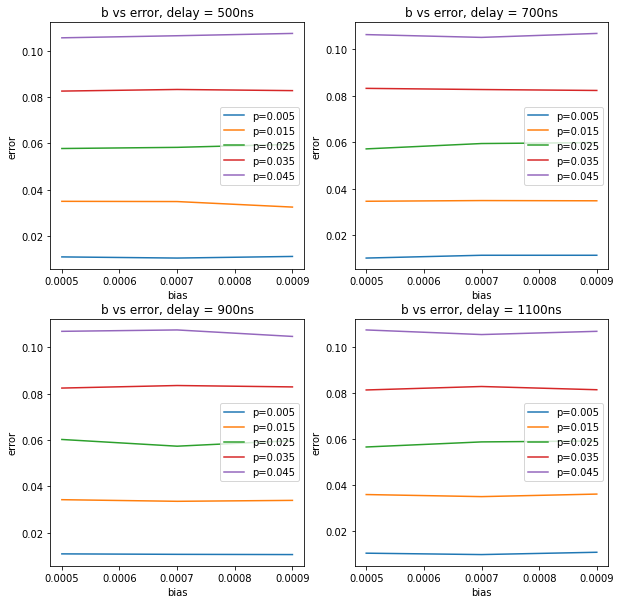

In [95]:

fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(10,10))

l1 = ax[0][0].plot(x_axis_b, array_3d[0][0])
l2 = ax[0][0].plot(x_axis_b, array_3d[0][1])
l3 = ax[0][0].plot(x_axis_b, array_3d[0][2])
l4 = ax[0][0].plot(x_axis_b, array_3d[0][3])
l5 = ax[0][0].plot(x_axis_b, array_3d[0][4])

#[0.005, 0.015, 0.025, 0.035, 0.045 ]
ax[0][0].legend(['p=0.005','p=0.015','p=0.025','p=0.035','p=0.045'])
ax[0][0].set_xlabel('bias')
ax[0][0].set_ylabel('error')
ax[0][0].set_title('b vs error, delay = 500ns')

l1 = ax[0][1].plot(x_axis_b, array_3d[1][0])
l2 = ax[0][1].plot(x_axis_b, array_3d[1][1])
l3 = ax[0][1].plot(x_axis_b, array_3d[1][2])
l4 = ax[0][1].plot(x_axis_b, array_3d[1][3])
l5 = ax[0][1].plot(x_axis_b, array_3d[1][4])

#[0.005, 0.015, 0.025, 0.035, 0.045 ]
ax[0][1].legend(['p=0.005','p=0.015','p=0.025','p=0.035','p=0.045'])
ax[0][1].set_xlabel('bias')
ax[0][1].set_ylabel('error')
ax[0][1].set_title('b vs error, delay = 700ns')

l1 = ax[1][0].plot(x_axis_b, array_3d[2][0])
l2 = ax[1][0].plot(x_axis_b, array_3d[2][1])
l3 = ax[1][0].plot(x_axis_b, array_3d[2][2])
l4 = ax[1][0].plot(x_axis_b, array_3d[2][3])
l5 = ax[1][0].plot(x_axis_b, array_3d[2][4])

#[0.005, 0.015, 0.025, 0.035, 0.045 ]
ax[1][0].legend(['p=0.005','p=0.015','p=0.025','p=0.035','p=0.045'])
ax[1][0].set_xlabel('bias')
ax[1][0].set_ylabel('error')
ax[1][0].set_title('b vs error, delay = 900ns')

l1 = ax[1][1].plot(x_axis_b, array_3d[3][0])
l2 = ax[1][1].plot(x_axis_b, array_3d[3][1])
l3 = ax[1][1].plot(x_axis_b, array_3d[3][2])
l4 = ax[1][1].plot(x_axis_b, array_3d[3][3])
l5 = ax[1][1].plot(x_axis_b, array_3d[3][4])

#[0.005, 0.015, 0.025, 0.035, 0.045 ]
ax[1][1].legend(['p=0.005','p=0.015','p=0.025','p=0.035','p=0.045'])
ax[1][1].set_xlabel('bias')
ax[1][1].set_ylabel('error')
ax[1][1].set_title('b vs error, delay = 1100ns')

plt.show()

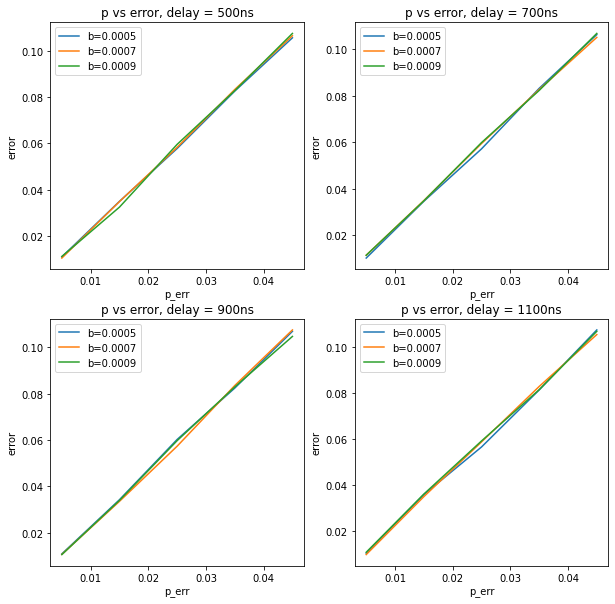

In [122]:

fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(10,10))

l1 = ax[0][0].plot(x_axis_p, array_3d[0,:,0])
l2 = ax[0][0].plot(x_axis_p, array_3d[0,:,1])
l3 = ax[0][0].plot(x_axis_p, array_3d[0,:,2])

#[0.0005, .0007, .0009]
ax[0][0].legend(['b=0.0005','b=0.0007','b=0.0009'])
ax[0][0].set_xlabel('p_err')
ax[0][0].set_ylabel('error')
ax[0][0].set_title('p vs error, delay = 500ns')

l1 = ax[0][1].plot(x_axis_p, array_3d[1,:,0])
l2 = ax[0][1].plot(x_axis_p, array_3d[1,:,1])
l3 = ax[0][1].plot(x_axis_p, array_3d[1,:,2])

#[0.0005, .0007, .0009]
ax[0][1].legend(['b=0.0005','b=0.0007','b=0.0009'])
ax[0][1].set_xlabel('p_err')
ax[0][1].set_ylabel('error')
ax[0][1].set_title('p vs error, delay = 700ns')

l1 = ax[1][0].plot(x_axis_p, array_3d[2,:,0])
l2 = ax[1][0].plot(x_axis_p, array_3d[2,:,1])
l3 = ax[1][0].plot(x_axis_p, array_3d[2,:,2])

#[0.0005, .0007, .0009]
ax[1][0].legend(['b=0.0005','b=0.0007','b=0.0009'])
ax[1][0].set_xlabel('p_err')
ax[1][0].set_ylabel('error')
ax[1][0].set_title('p vs error, delay = 900ns')

l1 = ax[1][1].plot(x_axis_p, array_3d[3,:,0])
l2 = ax[1][1].plot(x_axis_p, array_3d[3,:,1])
l3 = ax[1][1].plot(x_axis_p, array_3d[3,:,2])

#[0.0005, .0007, .0009]
ax[1][1].legend(['b=0.0005','b=0.0007','b=0.0009'])
ax[1][1].set_xlabel('p_err')
ax[1][1].set_ylabel('error')
ax[1][1].set_title('p vs error, delay = 1100ns')


plt.show()

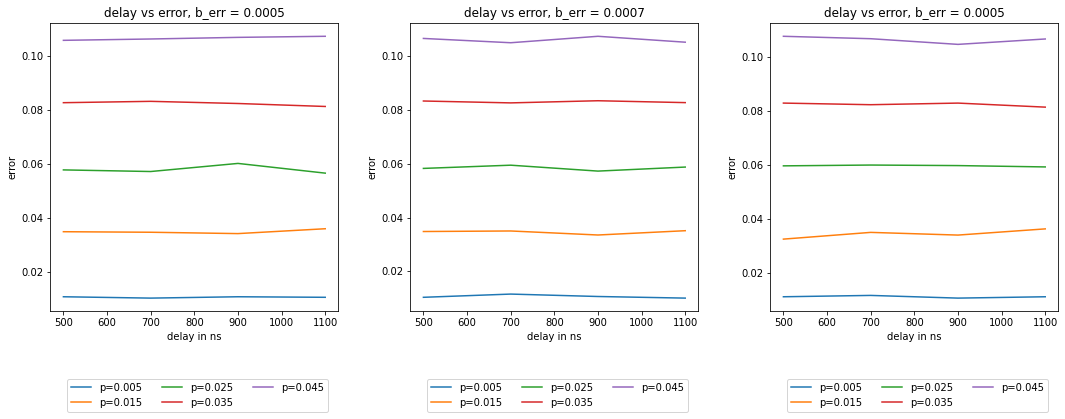

In [176]:
array_3d[0]
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(10,10))

l1 = ax[0].plot(x_axis_delay, array_3d[:,0,0])
l2 = ax[0].plot(x_axis_delay, array_3d[:,1,0])
l3 = ax[0].plot(x_axis_delay, array_3d[:,2,0])
l4 = ax[0].plot(x_axis_delay, array_3d[:,3,0])
l5 = ax[0].plot(x_axis_delay, array_3d[:,4,0])

#[0.005, 0.015, 0.025, 0.035, 0.045 ]
ax[0].legend(['p=0.005','p=0.015','p=0.025','p=0.035','p=0.045'],bbox_to_anchor=(1, -0.2), borderaxespad=1,ncol=3)
ax[0].set_xlabel('delay in ns')
ax[0].set_ylabel('error')
ax[0].set_title('delay vs error, b_err = 0.0005')


l1 = ax[1].plot(x_axis_delay, array_3d[:,0,1])
l2 = ax[1].plot(x_axis_delay, array_3d[:,1,1])
l3 = ax[1].plot(x_axis_delay, array_3d[:,2,1])
l4 = ax[1].plot(x_axis_delay, array_3d[:,3,1])
l5 = ax[1].plot(x_axis_delay, array_3d[:,4,1])

#[0.005, 0.015, 0.025, 0.035, 0.045 ]
ax[1].legend(['p=0.005','p=0.015','p=0.025','p=0.035','p=0.045'],bbox_to_anchor=(1, -0.2), borderaxespad=1,ncol=3)
ax[1].set_xlabel('delay in ns')
ax[1].set_ylabel('error')
ax[1].set_title('delay vs error, b_err = 0.0007')

l1 = ax[2].plot(x_axis_delay, array_3d[:,0,2])
l2 = ax[2].plot(x_axis_delay, array_3d[:,1,2])
l3 = ax[2].plot(x_axis_delay, array_3d[:,2,2])
l4 = ax[2].plot(x_axis_delay, array_3d[:,3,2])
l5 = ax[2].plot(x_axis_delay, array_3d[:,4,2])

#[0.005, 0.015, 0.025, 0.035, 0.045 ]
ax[2].legend(['p=0.005','p=0.015','p=0.025','p=0.035','p=0.045'],bbox_to_anchor=(1, -0.2), borderaxespad=1,ncol=3)
ax[2].set_xlabel('delay in ns')
ax[2].set_ylabel('error')
ax[2].set_title('delay vs error, b_err = 0.0005')

ax[0].set_position([0.1, 0.1, 0.4, 0.4])
ax[1].set_position([0.6, 0.1, 0.4, 0.4])
ax[2].set_position([1.1, 0.1, 0.4, 0.4])
plt.show()